# Set up imports:

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# --- Global Plotting Style Settings ---


In [27]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme(style="whitegrid", palette="viridis")

plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

# Define the CreditRiskEDA Class:

In [28]:
class CreditRiskEDA:
    def __init__(self, data_path, target_proxy_col='FraudResult'):
        """
        Initializes the EDA class by loading the dataset and setting up.

        Args:
            data_path (str): The file path to the dataset (e.g., 'data/raw/transactions.csv').
            target_proxy_col (str): The name of the column that indicates the fraud/risk outcome.
        """
        self.data_path = data_path
        self.target_proxy_col = target_proxy_col
        self.df = self._load_data()
        print("DataFrame loaded successfully with shape:", self.df.shape)
        self.numerical_cols = self.df.select_dtypes(include=np.number).columns.tolist()
        self.categorical_cols = self.df.select_dtypes(include='object').columns.tolist()

        # Remove ID columns and target from general numerical/categorical lists for plotting
        id_cols = ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId']
        self.numerical_cols = [col for col in self.numerical_cols if col not in id_cols and col != self.target_proxy_col]
        self.categorical_cols = [col for col in self.categorical_cols if col not in id_cols and col != self.target_proxy_col]


    def _load_data(self):
        """Loads the dataset from the specified path and performs initial type conversions."""
        try:
            df = pd.read_csv(self.data_path)
            # Convert TransactionStartTime to datetime
            df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
            return df
        except FileNotFoundError:
            print(f"Error: '{self.data_path}' not found. Please ensure the data file exists.")
            # Create dummy data with your specified fields for demonstration
            print("Creating dummy data for demonstration purposes with specified fields.")
            n_rows = 1000
            data = {
                'TransactionId': range(1, n_rows + 1),
                'BatchId': np.random.randint(1, 50, n_rows),
                'AccountId': np.random.randint(1000, 5000, n_rows),
                'SubscriptionId': np.random.randint(100, 300, n_rows),
                'CustomerId': np.random.randint(1000, 5000, n_rows),
                'CurrencyCode': np.random.choice(['KES', 'USD', 'EUR'], n_rows, p=[0.7, 0.2, 0.1]),
                'CountryCode': np.random.randint(254, 300, n_rows),
                'ProviderId': np.random.randint(1, 10, n_rows),
                'ProductId': np.random.randint(10000, 10010, n_rows),
                'ProductCategory': np.random.choice(['Bills', 'Airtime', 'Data', 'Other'], n_rows, p=[0.4, 0.3, 0.2, 0.1]),
                'ChannelId': np.random.choice(['Web', 'Android', 'IOS', 'Pay Later', 'Checkout'], n_rows),
                'Amount': np.random.uniform(-10000, 50000, n_rows), # Mixed positive/negative as per your description
                'Value': np.random.uniform(0, 50000, n_rows), # Absolute value
                'TransactionStartTime': pd.to_datetime('2024-01-01') + pd.to_timedelta(np.random.randint(0, 365*24*60*60, n_rows), unit='s'),
                'PricingStrategy': np.random.choice([1, 2, 3, 4, 5], n_rows),
                'FraudResult': np.random.choice([0, 1], n_rows, p=[0.95, 0.05]) # 5% fraud rate for dummy
            }
            return pd.DataFrame(data)

    def get_data_overview(self):
        """Prints basic information about the dataset."""
        print("\n--- Data Overview ---")
        print("First 5 rows:")
        print(self.df.head())
        print("\nDataFrame Info:")
        self.df.info()
        print(f"\nDataFrame Shape: {self.df.shape}")
        print(f"Columns: {self.df.columns.tolist()}")

    def get_summary_statistics(self):
        """Prints summary statistics for numerical and categorical features."""
        print("\n--- Summary Statistics ---")
        print("\nNumerical Features Summary:")
        print(self.df[self.numerical_cols + [self.target_proxy_col]].describe())
        print("\nCategorical Features Summary:")
        print(self.df[self.categorical_cols].describe(include='object'))

    def plot_numerical_distributions(self):
        """Plots histograms/KDEs and violin plots side-by-side for numerical features."""
        print("\n--- Numerical Feature Distributions ---")
        for col in self.numerical_cols:
            # Create a figure with two subplots side-by-side
            fig, axes = plt.subplots(1, 2, figsize=(18, 7))

            # Histogram/KDE plot
            sns.histplot(self.df[col], kde=True, bins=30, ax=axes[0], color=sns.color_palette("viridis")[0])
            axes[0].set_title(f'Distribution of {col} (Histogram/KDE)', fontsize=16, fontweight='bold')
            axes[0].set_xlabel(col, fontsize=14)
            axes[0].set_ylabel('Frequency', fontsize=14)
            axes[0].grid(True, linestyle='--', alpha=0.6)

            # Violin plot for distribution shape and outlier detection
            sns.violinplot(y=self.df[col], ax=axes[1], color=sns.color_palette("plasma")[1], inner='quartile')
            axes[1].set_title(f'Violin Plot of {col}', fontsize=16, fontweight='bold')
            axes[1].set_ylabel(col, fontsize=14)
            axes[1].grid(axis='y', linestyle='--', alpha=0.6)

            plt.suptitle(f'Analysis of {col}', fontsize=20, fontweight='bold', y=1.02)
            plt.tight_layout(rect=[0, 0, 1, 0.98])
            plt.show()

    def plot_categorical_distributions(self):
        """Plots count plots for categorical features with enhanced aesthetics."""
        print("\n--- Categorical Feature Distributions ---")
        for col in self.categorical_cols:
            if self.df[col].nunique() > 20:
                print(f"Skipping count plot for {col} due to too many unique categories ({self.df[col].nunique()}). Showing value counts instead.")
                print(self.df[col].value_counts().head(10))
                continue

            plt.figure(figsize=(12, 7))
            sns.countplot(data=self.df, x=col, order=self.df[col].value_counts().index, hue=col, palette='viridis', legend=False)

            plt.title(f'Distribution of {col}', fontsize=16, fontweight='bold')
            plt.xlabel(col, fontsize=14)
            plt.ylabel('Count', fontsize=14)
            plt.xticks(rotation=45, ha='right', fontsize=12)
            plt.yticks(fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

    def analyze_correlation(self):
        """Calculates and visualizes the correlation matrix for numerical features with enhanced aesthetics."""
        print("\n--- Correlation Analysis ---")
        corr_cols = self.numerical_cols + [self.target_proxy_col]
        corr_matrix = self.df[corr_cols].corr()

        plt.figure(figsize=(14, 12))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.7, linecolor='black', cbar_kws={'label': 'Correlation Coefficient'})
        plt.title('Correlation Matrix of Numerical Features (including FraudResult)', fontsize=18, fontweight='bold')
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plt.tight_layout()
        plt.show()
        return corr_matrix

    def identify_missing_values(self):
        """Identifies and reports missing values, and visualizes them with missingno."""
        print("\n--- Missing Values Analysis ---")
        missing_data = self.df.isnull().sum()
        missing_data = missing_data[missing_data > 0]
        if missing_data.empty:
            print("No missing values found in the dataset.")
        else:
            missing_percentage = (missing_data / len(self.df) * 100).round(2)
            missing_df = pd.DataFrame({'Missing Count': missing_data, 'Percentage (%)': missing_percentage})
            print(missing_df.sort_values(by='Percentage (%)', ascending=False))

            plt.figure(figsize=(12, 8))
            msno.bar(self.df, color=sns.color_palette("viridis")[2], fontsize=12, figsize=(12, 8))
            plt.title('Missing Data Count and Percentage', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()


    def detect_outliers(self):
        """
        Outliers are now visually represented in the violin plots within `plot_numerical_distributions`.
        This method will confirm that.
        """
        print("\n--- Outlier Detection ---")
        print("Outliers for numerical features are visually represented in the violin plots within 'plot_numerical_distributions' method.")
        print("You can also programmatically detect and list them if needed, e.g., using IQR method.")

    def analyze_target_proxy(self):
        """
        Performs specific analysis related to the target proxy (FraudResult) with enhanced aesthetics.
        """
        print(f"\n--- Analysis of Target Proxy: '{self.target_proxy_col}' ---")

        # Distribution of FraudResult
        plt.figure(figsize=(8, 5))
        sns.countplot(data=self.df, x=self.target_proxy_col, hue=self.target_proxy_col, palette='pastel', legend=False)

        plt.title(f'Distribution of {self.target_proxy_col}', fontsize=16, fontweight='bold')
        plt.xlabel(self.target_proxy_col, fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        fraud_dist = self.df[self.target_proxy_col].value_counts(normalize=True).round(4) * 100
        print(f"Distribution of {self.target_proxy_col} (%):\n{fraud_dist}")
        print(f"Fraud Rate: {fraud_dist.get(1, 0):.2f}%")

        # Relationship with numerical features (violin plot and KDE side-by-side)
        print("\n--- Fraud vs. Numerical Features (Violin Plots & KDEs) ---")
        for col in self.numerical_cols:
            fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey='row')

            # Violin plot - FIX APPLIED HERE for palette warning
            sns.violinplot(data=self.df, x=self.target_proxy_col, y=col, ax=axes[0], 
                           hue=self.target_proxy_col, palette='deep', inner='quartile', legend=False)
            # END FIX

            axes[0].set_title(f'Violin Plot of {col} by {self.target_proxy_col}', fontsize=16, fontweight='bold')
            axes[0].set_xlabel(self.target_proxy_col, fontsize=14)
            axes[0].set_ylabel(col, fontsize=14)
            axes[0].grid(axis='y', linestyle='--', alpha=0.6)

            # KDE plot - FIX APPLIED HERE for 0 variance warning
            sns.kdeplot(data=self.df, x=col, hue=self.target_proxy_col, fill=True, common_norm=False, 
                        palette='dark', linewidth=2, ax=axes[1], warn_singular=False)
            # END FIX

            axes[1].set_title(f'KDE of {col} by {self.target_proxy_col}', fontsize=16, fontweight='bold')
            axes[1].set_xlabel(col, fontsize=14)
            axes[1].set_ylabel('Density', fontsize=14)

            # Check if there are labels to put in the legend before calling legend()
            # This explicitly handles the "No artists with labels" warning
            handles, labels = axes[1].get_legend_handles_labels()
            if handles: # Only draw legend if there are items to legend
                axes[1].legend(title=self.target_proxy_col, loc='upper right')
            else:
                # You might want to print a message if a legend isn't drawn for a reason
                print(f"  Note: No legend drawn for KDE of {col} due to singular data or missing labels.")

            axes[1].grid(True, linestyle='--', alpha=0.6)

            plt.suptitle(f'Impact of {col} on {self.target_proxy_col}', fontsize=20, fontweight='bold', y=1.02)
            plt.tight_layout(rect=[0, 0, 1, 0.98])
            plt.show()


        # Relationship with categorical features (stacked bar chart is often best for proportions)
        print("\n--- Fraud vs. Categorical Features (Proportions) ---")
        for col in self.categorical_cols:
            print(f"\nAnalysis for: {col}")
            if self.df[col].nunique() > 20:
                print(f"Skipping detailed fraud plot for {col} due to too many unique categories ({self.df[col].nunique()}). Showing top 10 fraud rates instead.")
                crosstab_norm = pd.crosstab(self.df[col], self.df[self.target_proxy_col], normalize='index').mul(100).round(2)
                print(crosstab_norm.sort_values(by=1, ascending=False).head(10))
                continue

            crosstab_norm = pd.crosstab(self.df[col], self.df[self.target_proxy_col], normalize='index').mul(100).round(2)
            print(crosstab_norm)

            ax = crosstab_norm.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
            plt.title(f'Fraud Proportion by {col}', fontsize=18, fontweight='bold')
            plt.xlabel(col, fontsize=14)
            plt.ylabel('Proportion (%)', fontsize=14)
            plt.xticks(rotation=45, ha='right', fontsize=12)
            plt.yticks(fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.legend(title=self.target_proxy_col, loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
            plt.tight_layout(rect=[0, 0, 0.9, 1])
            plt.show()


    def run_all_eda(self):
        """Executes all standard EDA steps."""
        self.get_data_overview()
        self.get_summary_statistics()
        self.identify_missing_values()
        self.plot_numerical_distributions()
        self.plot_categorical_distributions()
        self.analyze_correlation()
        self.detect_outliers()
        self.analyze_target_proxy()

# Execute the EDA 

### Initialize the EDA object with actual data path

In [29]:
eda = CreditRiskEDA(data_path='../data/raw/data.csv', target_proxy_col='FraudResult')

DataFrame loaded successfully with shape: (95662, 16)


## Run all the defined EDA steps


--- Data Overview ---
First 5 rows:
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    Channe

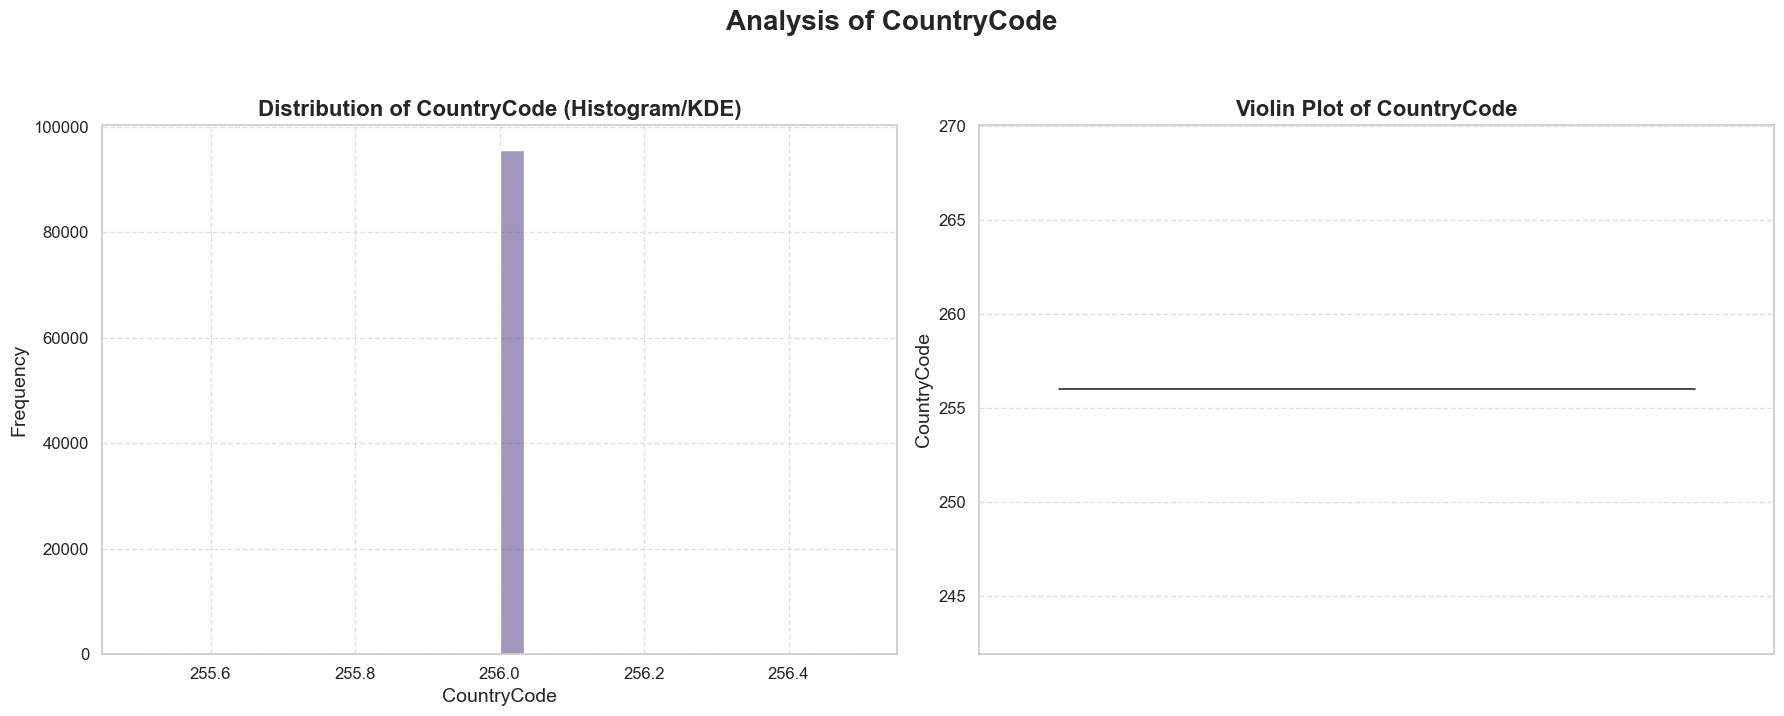

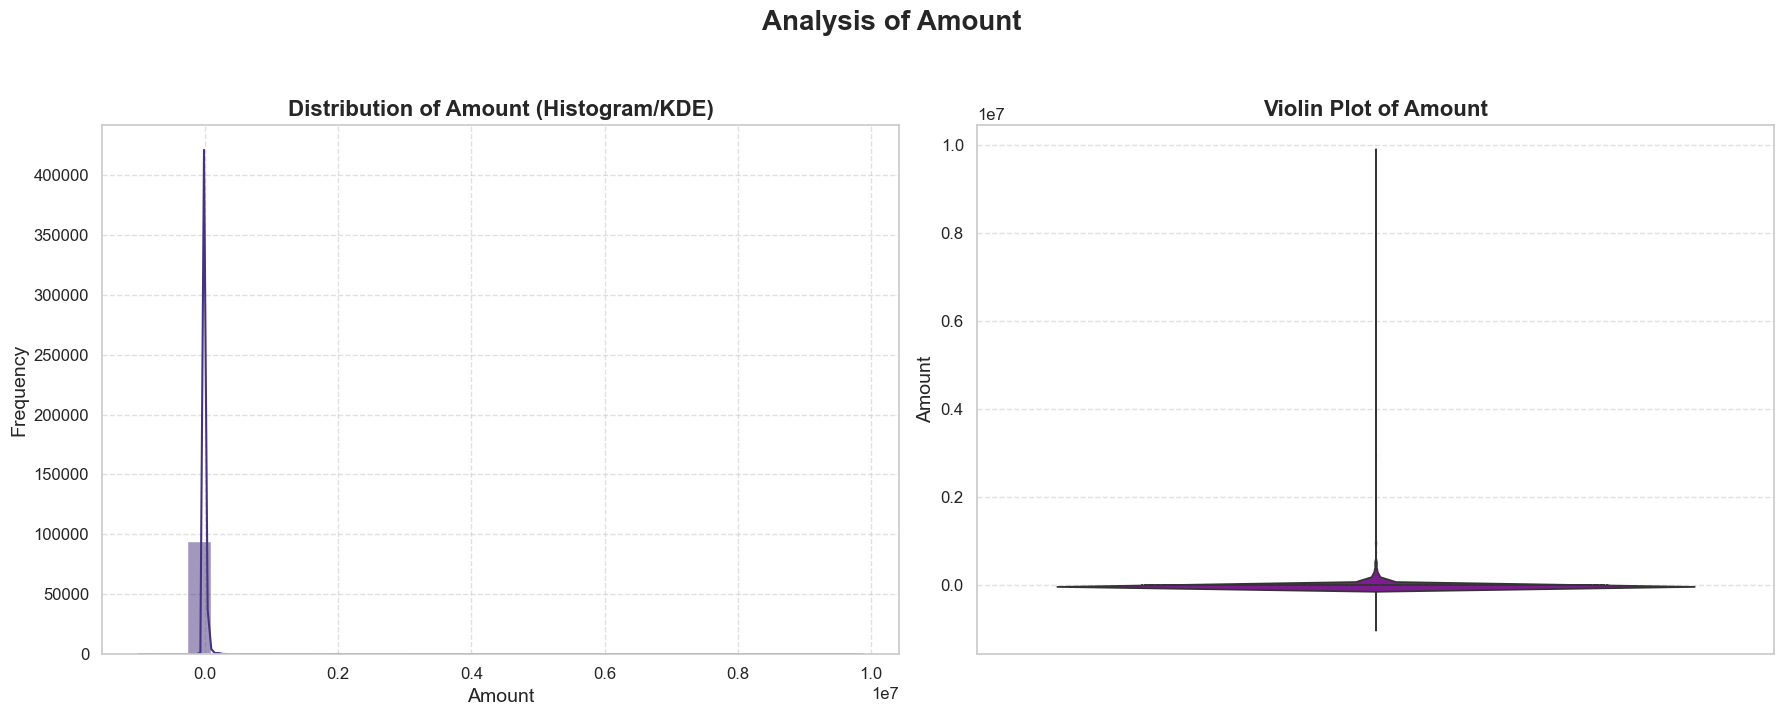

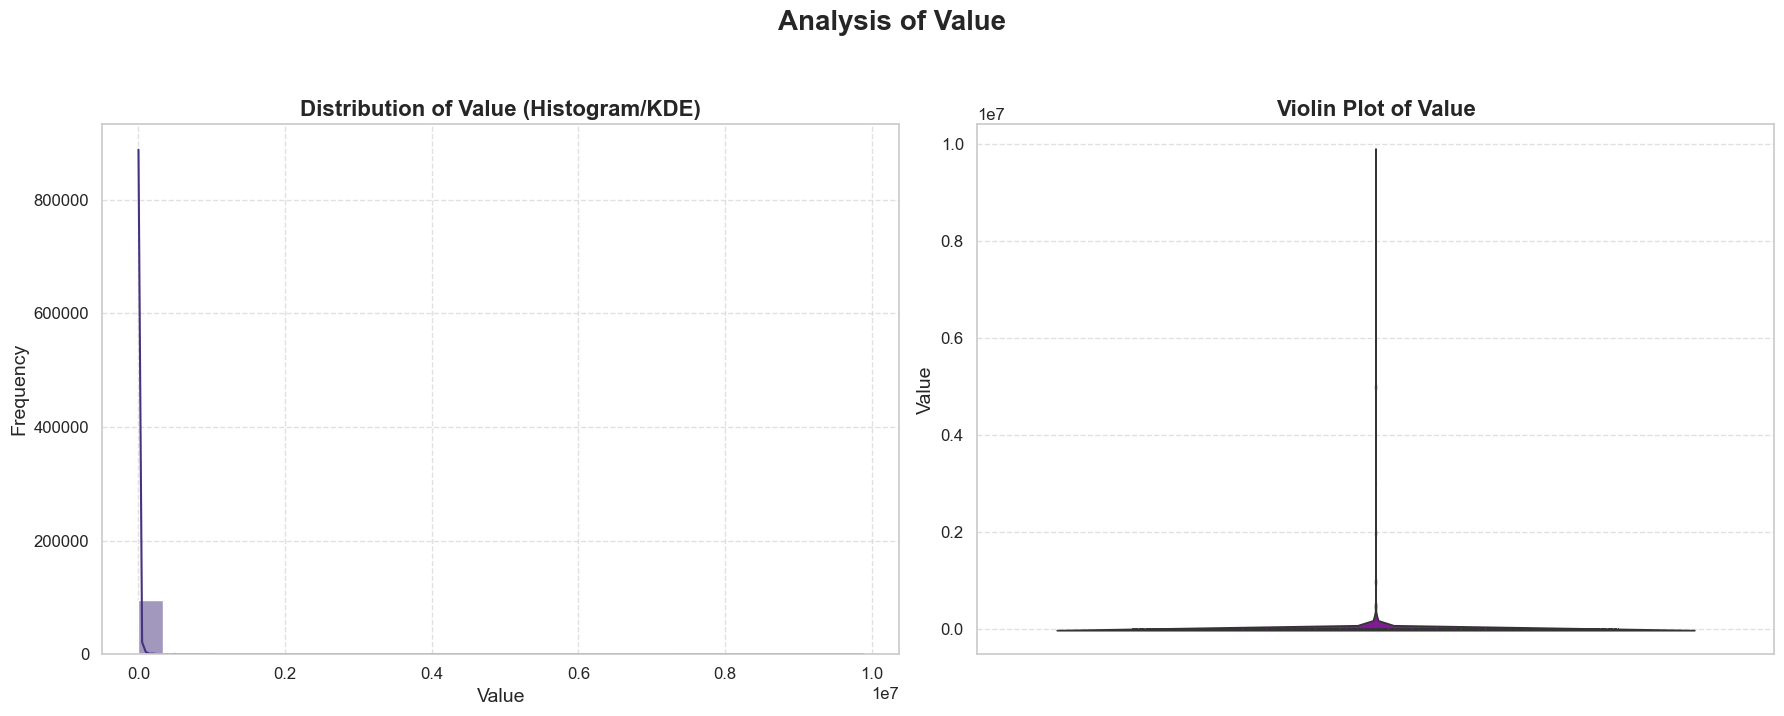

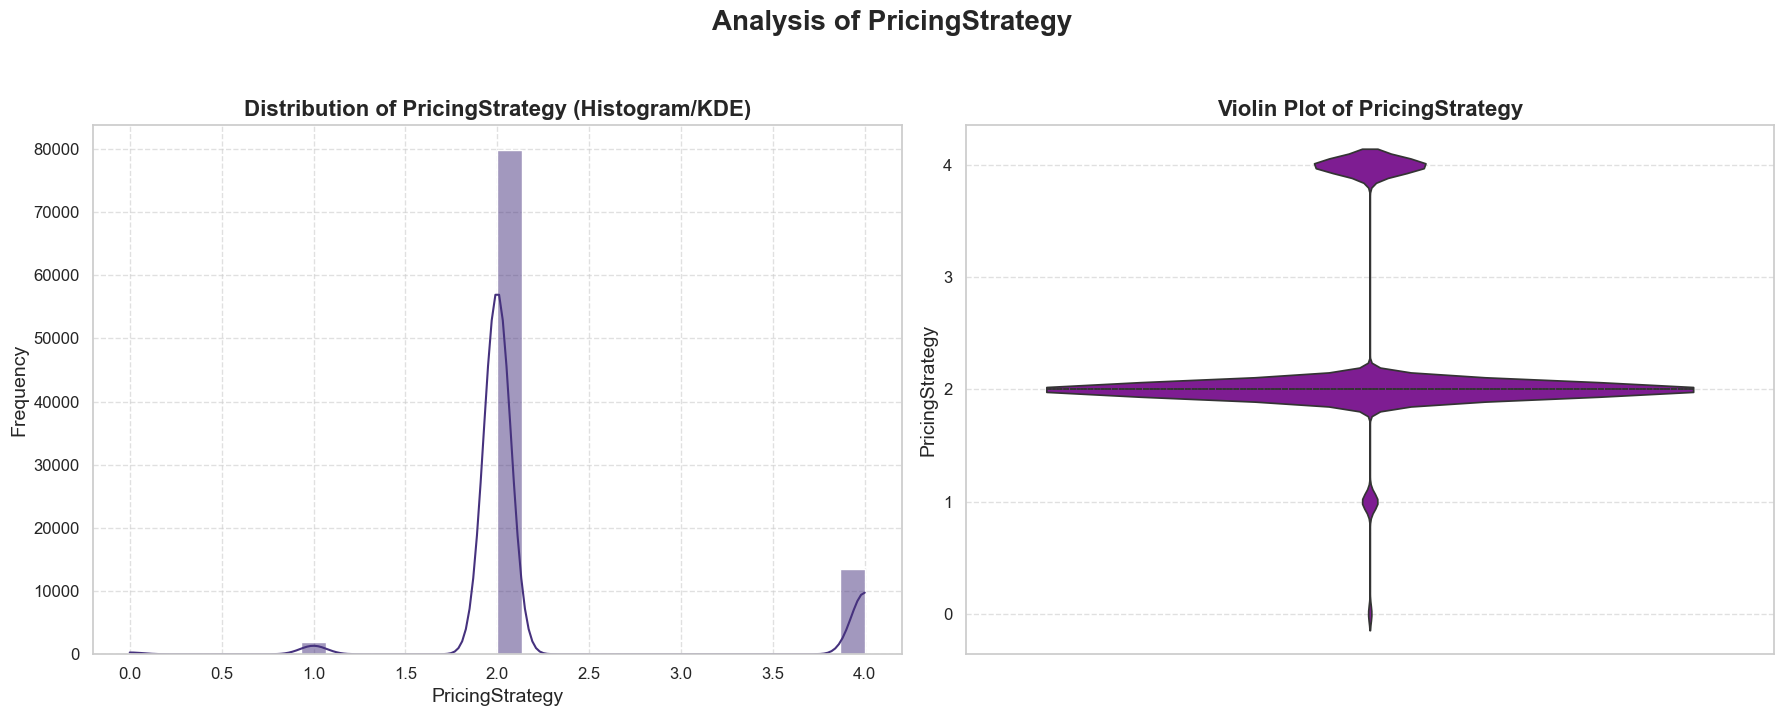


--- Categorical Feature Distributions ---


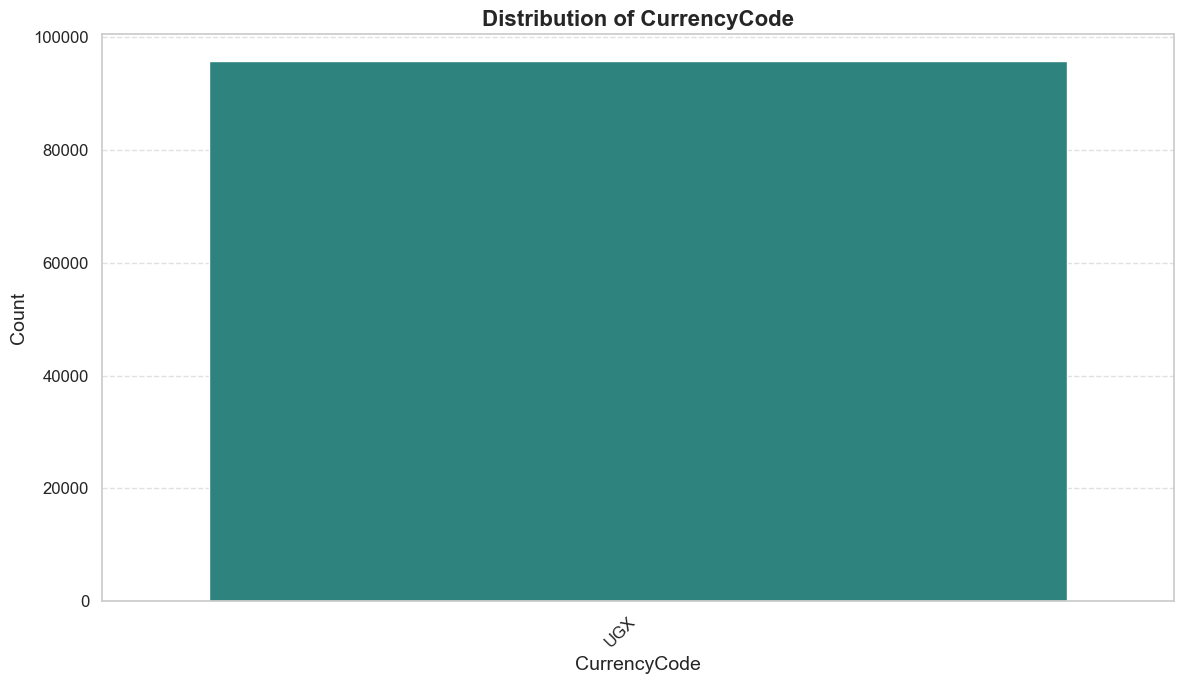

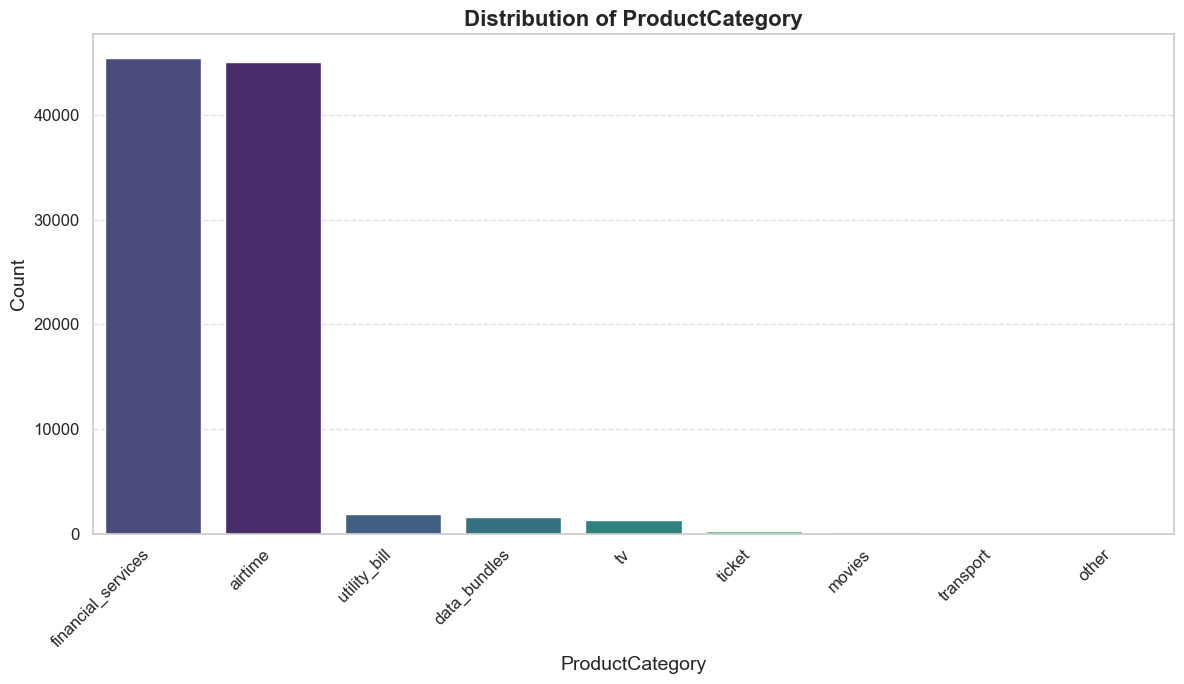

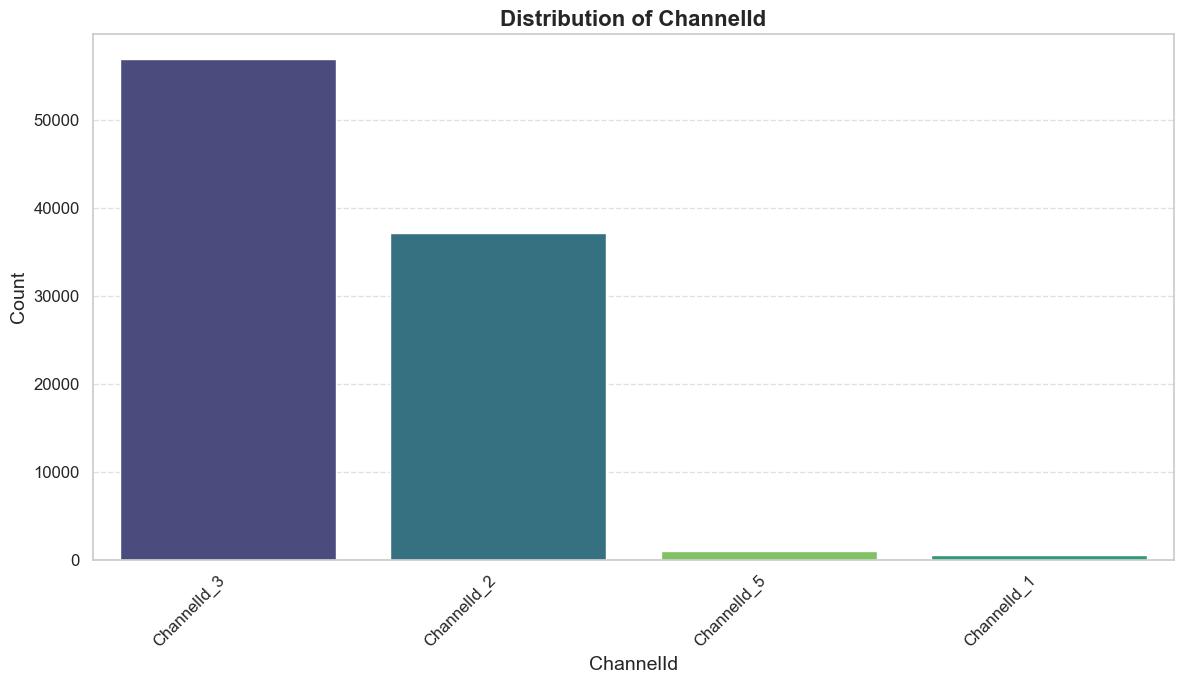


--- Correlation Analysis ---


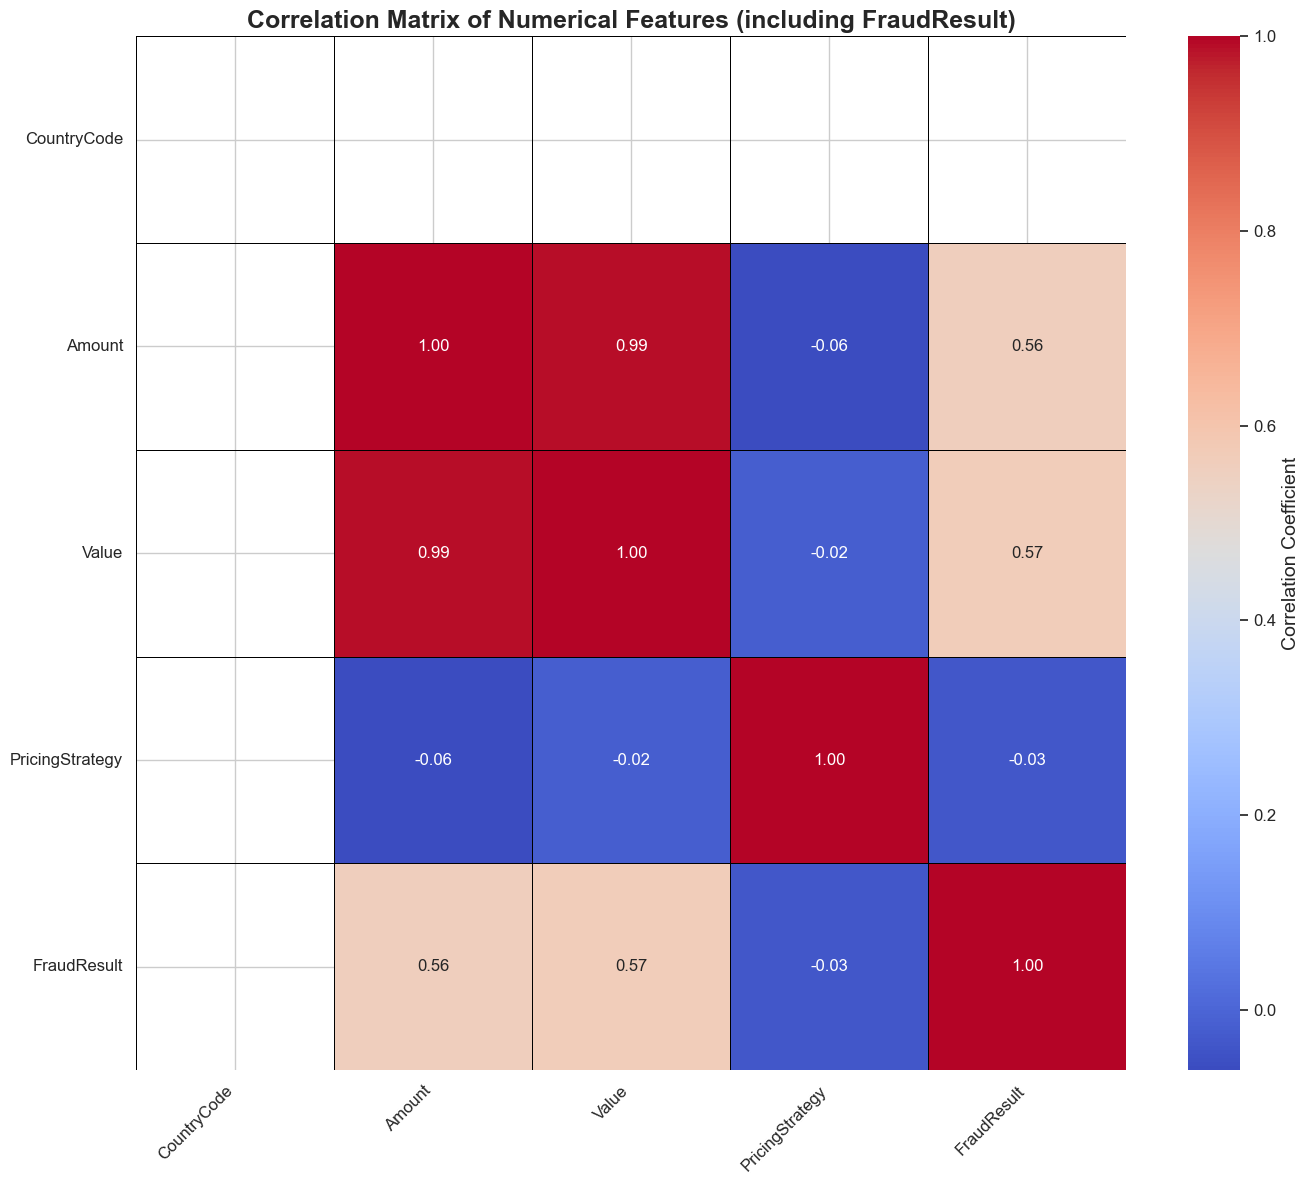


--- Outlier Detection ---
Outliers for numerical features are visually represented in the violin plots within 'plot_numerical_distributions' method.
You can also programmatically detect and list them if needed, e.g., using IQR method.

--- Analysis of Target Proxy: 'FraudResult' ---


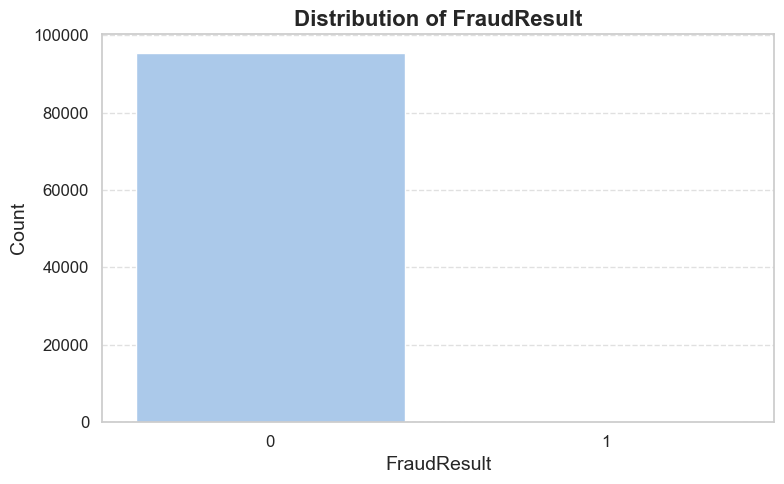

Distribution of FraudResult (%):
FraudResult
0    99.8
1     0.2
Name: proportion, dtype: float64
Fraud Rate: 0.20%

--- Fraud vs. Numerical Features (Violin Plots & KDEs) ---
  Note: No legend drawn for KDE of CountryCode due to singular data or missing labels.


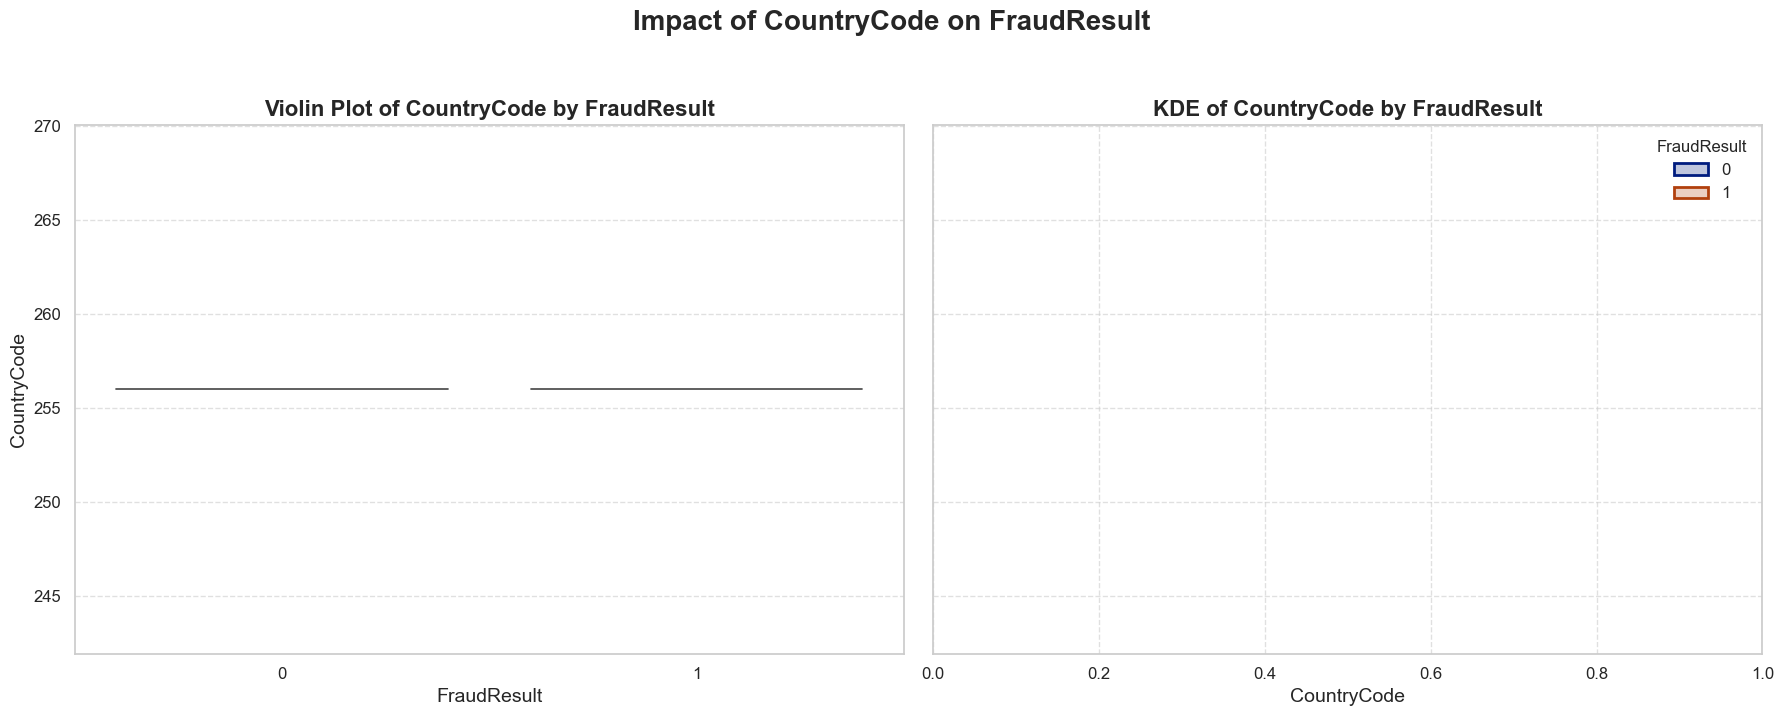

  Note: No legend drawn for KDE of Amount due to singular data or missing labels.


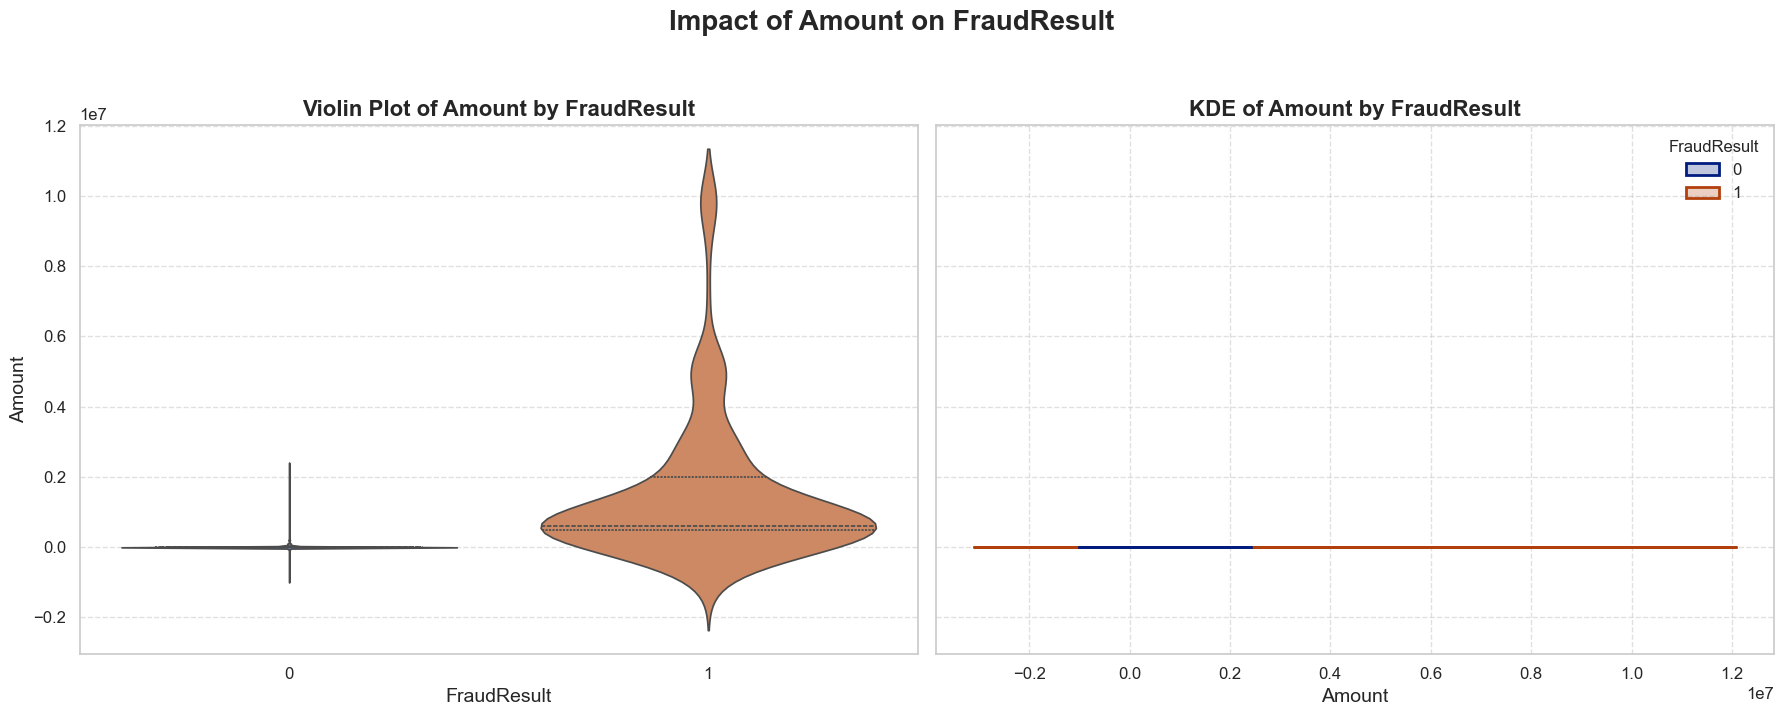

  Note: No legend drawn for KDE of Value due to singular data or missing labels.


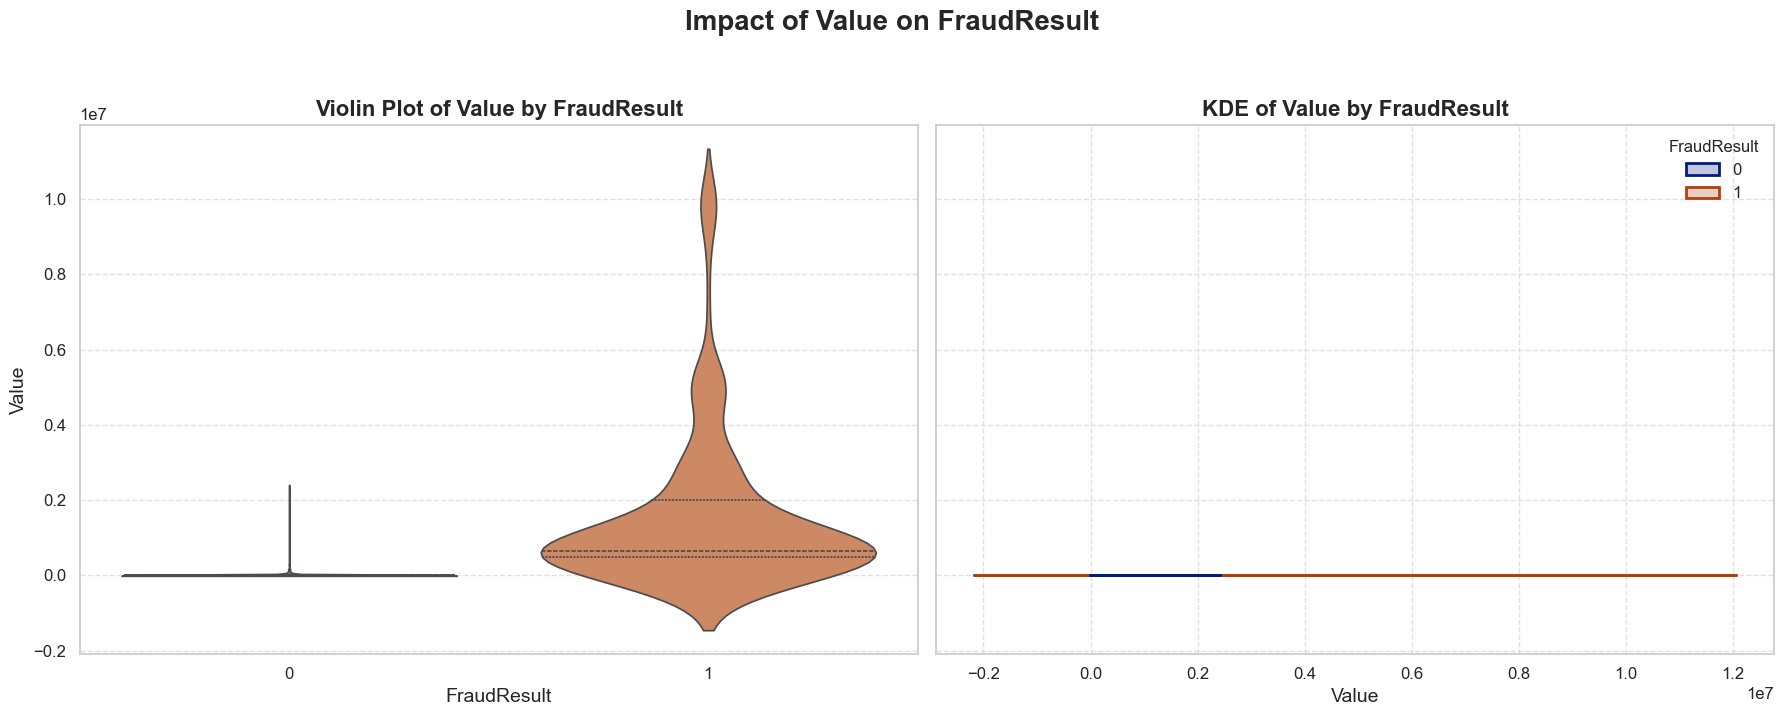

  Note: No legend drawn for KDE of PricingStrategy due to singular data or missing labels.


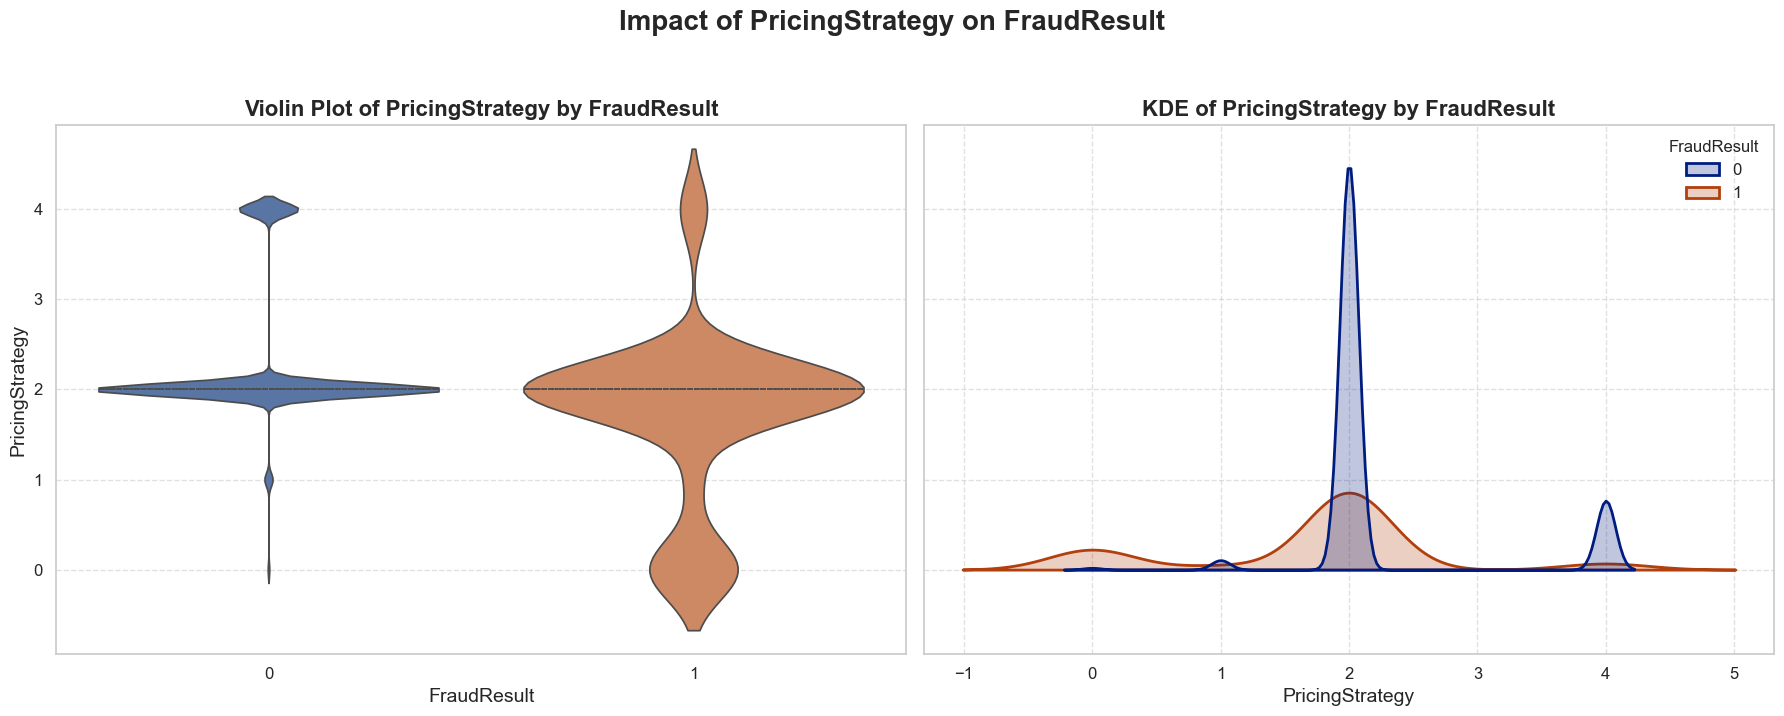


--- Fraud vs. Categorical Features (Proportions) ---

Analysis for: CurrencyCode
FraudResult      0    1
CurrencyCode           
UGX           99.8  0.2


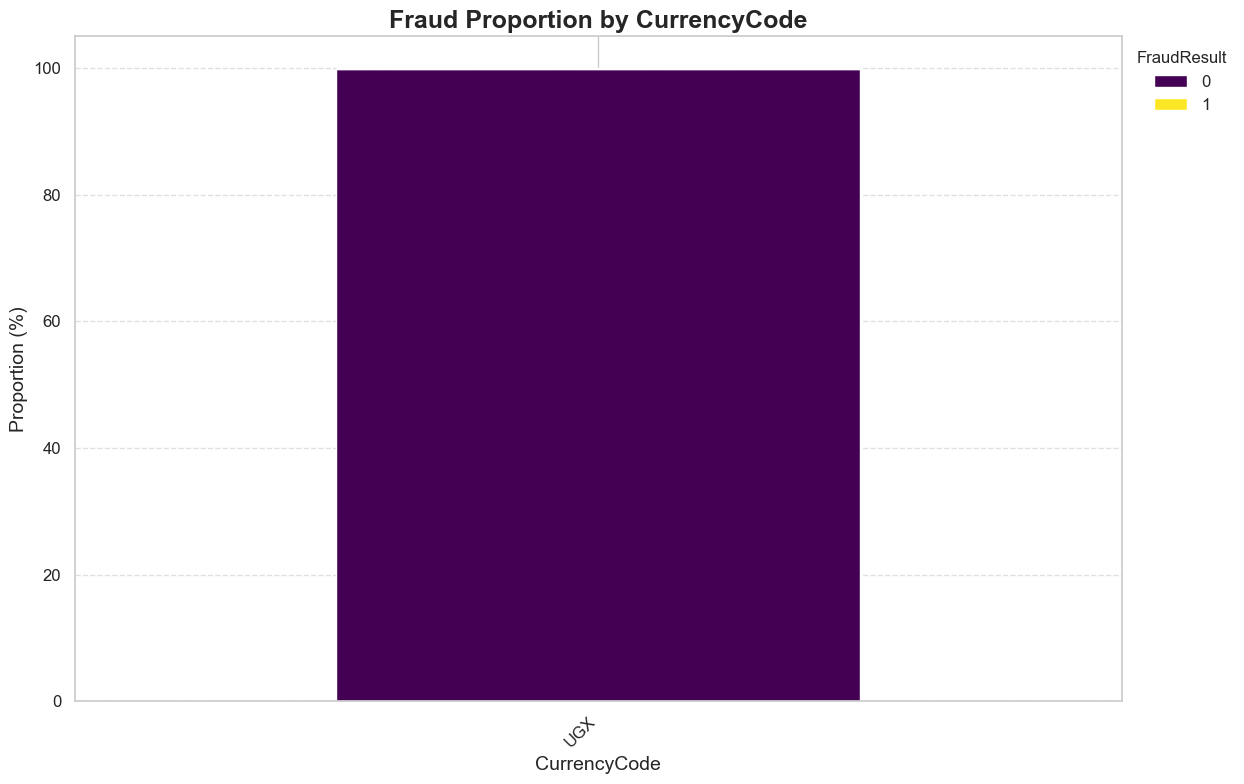


Analysis for: ProductCategory
FraudResult              0     1
ProductCategory                 
airtime              99.96  0.04
data_bundles        100.00  0.00
financial_services   99.65  0.35
movies              100.00  0.00
other               100.00  0.00
ticket              100.00  0.00
transport            92.00  8.00
tv                  100.00  0.00
utility_bill         99.38  0.62


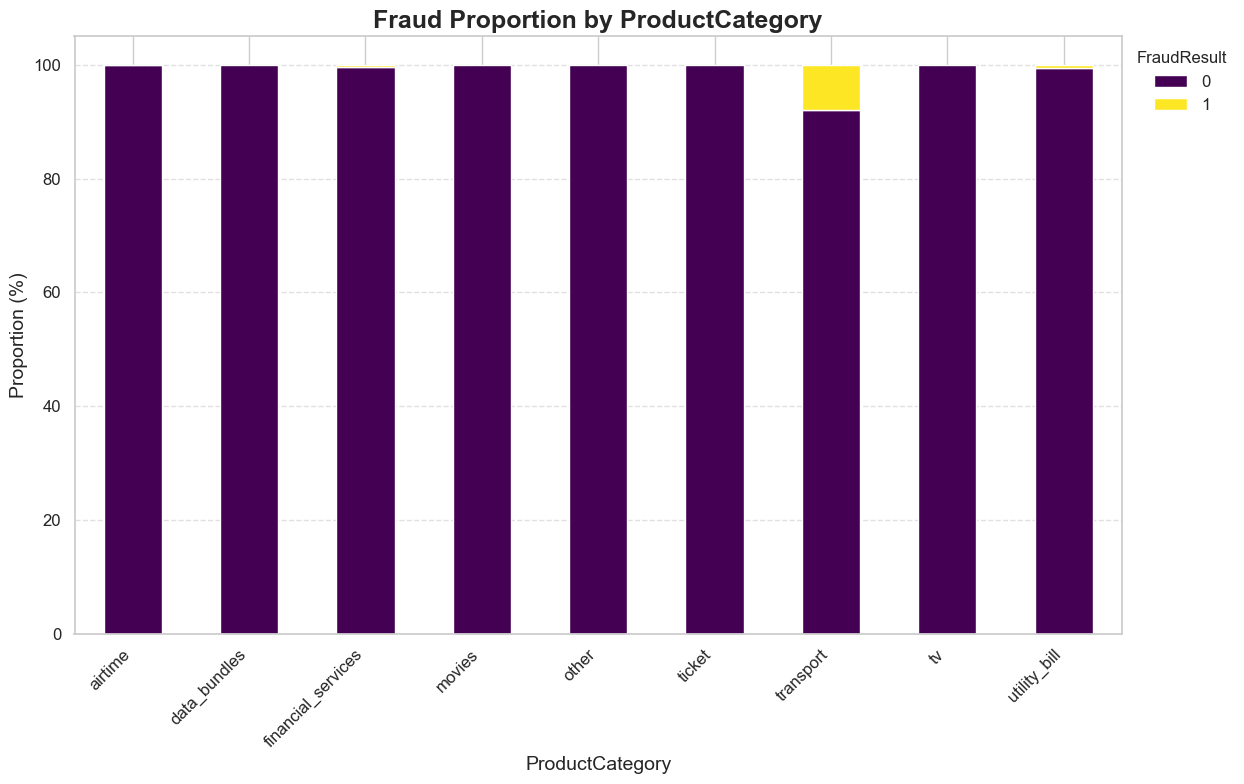


Analysis for: ChannelId
FraudResult       0     1
ChannelId                
ChannelId_1   99.26  0.74
ChannelId_2   99.99  0.01
ChannelId_3   99.68  0.32
ChannelId_5  100.00  0.00


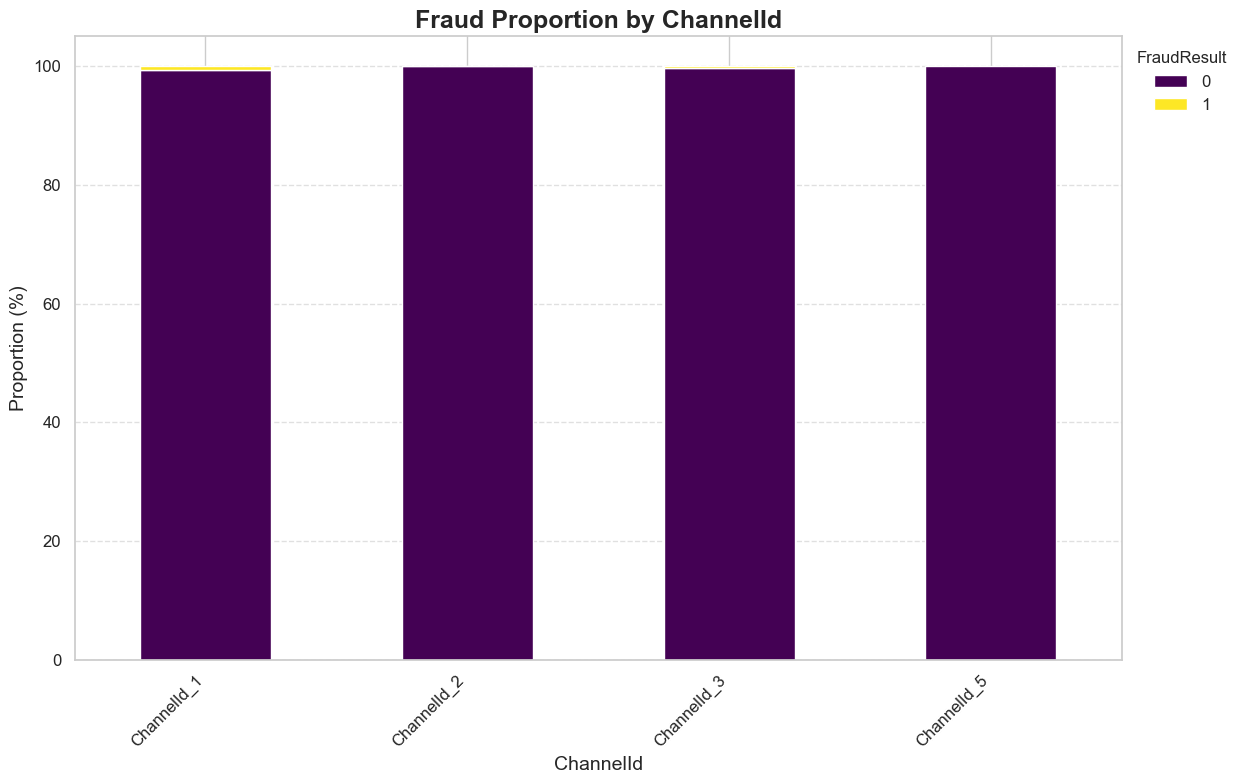

In [30]:
eda.run_all_eda()

## --- Manual analysis and Key Findings ---


1.  **Extremely Low Overall Fraud Rate (Severe Class Imbalance):**
    * **Insight:** The dataset exhibits a highly imbalanced target variable, with only **0.20%** of transactions classified as fraudulent. The vast majority (**99.80%**) are legitimate.
    * **Implication:** This severe class imbalance is a critical challenge for machine learning model development. Standard classification algorithms may struggle to effectively learn the patterns of the minority (fraudulent) class. Addressing this will require specialized techniques such as oversampling (e.g., SMOTE), undersampling, or using algorithms inherently robust to imbalance (e.g., tree-based models with adjusted class weights, Isolation Forest).

2.  **Fraud Concentration in Specific Product Categories:**
    * **Insight:** While most product categories show negligible or no fraud, transactions related to **`transport`** exhibit a significantly elevated fraud rate of **8.00%**. Other categories like **`utility_bill` (0.62%)** and **`financial_services` (0.35%)** also show higher-than-average fraud. Categories like `data_bundles`, `movies`, `other`, `ticket`, and `tv` had no observed fraud in the sample provided.
    * **Implication:** `transport`, `utility_bill`, and `financial_services` represent high-risk areas. Features associated with these categories are likely to be strong indicators of fraud and should be carefully considered for feature engineering and model training. This pattern suggests potential fraud schemes targeting specific types of services or payment behaviors.

3.  **Channel-Specific Fraud Vulnerabilities:**
    * **Insight:** Fraudulent activity is not uniformly distributed across transaction channels. **`ChannelId_1`** shows the highest observed fraud rate at **0.74%**, followed by **`ChannelId_3` at 0.32%**. In contrast, `ChannelId_2` has a very low fraud rate (0.01%), and `ChannelId_5` had no fraud in the sample.
    * **Implication:** Certain channels appear to be more susceptible to fraud. This could be due to varying security protocols, user bases, or transaction types associated with each channel. Further investigation into the operational aspects and transaction characteristics of `ChannelId_1` and `ChannelId_3` is warranted to identify specific vulnerabilities.

4.  **Currency Code as a Potential Contextual Factor:**
    * **Insight:** The `CurrencyCode` 'UGX' (Ugandan Shilling) shows fraud at a rate consistent with the overall dataset (0.2%).
    * **Implication:** While not a strong differentiator in this limited sample for 'UGX' alone, `CurrencyCode` remains an important contextual feature. If the dataset contains other currencies, comparing their individual fraud rates could reveal geographic or currency-specific fraud patterns.

---